### Setup

In [ ]:
!pip install camel-tools
!pip install -U transformers
!pip install networkx
!pip install conllu==6.0.0
!pip install gensim==4.3.3

# Baseline Method (Rule-based)

In [ ]:
import json
import os
import re
import torch

from camel_tools.utils.dediac import dediac_ar
from camel_tools.utils.normalize import normalize_alef_ar, normalize_teh_marbuta_ar, normalize_alef_maksura_ar

from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.morphology.database import MorphologyDB
from camel_tools.morphology.analyzer import Analyzer


import networkx as nx
import matplotlib.pyplot as plt


In [ ]:
# List available packages
!camel_data --list

Package Name                      Size  License     Description
----------------------------  --------  ----------  -------------------------------------------------------------------------------------------------------------------------
all                                                 All available CAMeL Tools packages
defaults                                            Default datasets for all CAMeL Tools components
dialectid-all                                       All available dialect identification models
dialectid-model26             371.2 MB  MIT         Dialect identification model trained to differentiating between 25 Arabic city dialects as well as Modern Standard Arabic
dialectid-model6              153.0 MB  MIT         Dialect identification model trained to differentiating between 5 Arabic city dialects as well as Modern Standard Arabic
disambig-bert-unfactored-all                        All available unfactored BERT disambiguation models
disambig-bert-unfactored-egy

In [ ]:
import subprocess
import sys

# Install the MSA morphology database
try:
    result = subprocess.run([
        sys.executable, '-m', 'camel_tools.cli.camel_data',
        '--install', 'morphology-db-msa-r13'
    ], capture_output=True, text=True, timeout=300)

    print("Return code:", result.returncode)
    print("STDOUT:", result.stdout)

    if result.stderr:
        print("STDERR:", result.stderr)

    if result.returncode == 0:
        print("Database installed successfully!")
    else:
        print("Installation failed")

except Exception as e:
    print(f"Error: {e}")

Return code: 0
STDOUT: The following packages will be installed: 'morphology-db-msa-r13'

STDERR: 

Extracting package 'morphology-db-msa-r13':   0%|          | 0.00/40.5M [00:00<?, ?B/s]
Extracting package 'morphology-db-msa-r13': 100%|██████████| 40.5M/40.5M [00:00<00:00, 604MB/s]

Database installed successfully!


In [ ]:
# Use the full path to the database file
db_path = '/root/.camel_tools/data/morphology_db/calima-msa-r13/morphology.db'
analyzer = Analyzer(MorphologyDB(db_path))

print("✓ Analyzer created successfully!")

✓ Analyzer created successfully!


In [ ]:
def pos_camel(text:str):
    # tokenize
    tokens = simple_word_tokenize(text)

    # Analyze each token
    for token in tokens:
        analyses = analyzer.analyze(token)
        if analyses:
            # Take first analysis as baseline POS
            pos = analyses[0]['pos']
        else:
            pos = "UNK"  # Unknown
        print(f"{token}\t{pos}")


In [ ]:
text ='''عايز أروح Google بالتاكسي،
بس كتبت كتب كتير في البيت وبالمدرسة.
'''
pos_camel(text)

عايز	noun
أروح	verb
Google	foreign
بالتاكسي	noun
،	punc
بس	verb
كتبت	verb
كتب	noun
كتير	UNK
في	abbrev
البيت	noun
وبالمدرسة	noun
.	punc


**Limitaions**
1. No contextual disambiguation (rule-based, not deep learning).
2. Works only for MSA, poor on dialects.
3. Can’t handle foreign named entities.
4. Over-segmentation or missed clitics.

# DeepLearning Methods

### 1. Import libraries

In [2]:
import conllu
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import numpy as np

#encode the corpus to numbers
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim


#build the lstm

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding ,Bidirectional ,LSTM ,TimeDistributed,InputLayer,Conv1D,GRU ,SimpleRNN ,Dropout
from tensorflow.keras.callbacks import EarlyStopping


#performance evaluation
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix

#save model
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

### 2.Load data

In [4]:
file_path ='/content/ar_pud-ud-test.conllu'
with open(file_path ,mode='r',encoding='utf-8') as f:
  data = f.read()


type(data)

str

In [5]:
print(data[1:100]) # it will show first 20 character

 newdoc id = n01001
# sent_id = n01001011
# text = كتبت كوري شولمان, المساعدة الخاصة لأوباما في تدو


In [6]:
sentences =conllu.parse(data)
sentences[0].metadata

{'newdoc id': 'n01001',
 'sent_id': 'n01001011',
 'text': 'كتبت كوري شولمان, المساعدة الخاصة لأوباما في تدوينة نشرتها يوم الإثنين: "فيما الكثير من عمليات الانتقال الرقمي غير مسبوقة في الولايات المتحدة, فإن الانتقال السلمي للسلطة سبق له أن حدث".',
 'original_text': 'كتبت كوري شولمان, المساعدة الخاصة لأوباما في تدوينة نشرتها يوم الإثنين: "فيما الكثير من عمليات الانتقال الرقمي غير مسبوقة في الولايات المتحدة, فإن الانتقال السلمي للسلطة سبق له أن حدث".',
 'text_en': '“While much of the digital transition is unprecedented in the United States, the peaceful transition of power is not,” Obama special assistant Kori Schulman wrote in a blog post Monday.'}

In [7]:
sentences[0][0]

{'id': 1,
 'form': 'كتبت',
 'lemma': 'كَتَب',
 'upos': 'VERB',
 'xpos': 'VBC',
 'feats': {'Aspect': 'Perf',
  'Gender': 'Fem',
  'Number': 'Sing',
  'Person': '3',
  'Tense': 'Past',
  'Voice': 'Act'},
 'head': 0,
 'deprel': 'root',
 'deps': None,
 'misc': {'LId': 'كَتَب-ُ_1'}}

In [8]:
sentences[0][1]

{'id': 2,
 'form': 'كوري',
 'lemma': 'كوري',
 'upos': 'PROPN',
 'xpos': 'NNP',
 'feats': {'Case': 'Nom', 'Gender': 'Fem', 'Number': 'Sing'},
 'head': 1,
 'deprel': 'nsubj',
 'deps': None,
 'misc': {'LId': 'كوري_0'}}

### 3.Preprocessing

In [9]:
def remove_tashkeel(w):
    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    w = re.sub(p_tashkeel,"", w)
    return w

In [10]:
import re

corpus = []                            # list of dictionaries, each dict is a sentence
list_pos = []                          # A flat list of all POS tags (from all sentences).
list_words = []                        # A flat list of all words (after preprocessing).
pos = []                               # A list of POS tags per sentence (nested list).
list_sentences = []                    # Stores raw text of sentences (from metadata).

# Regex to skip English sentences
re_pattern = re.compile(r'[a-zA-Z]+')

for sentence in sentences:
    sentence_txt = sentence.metadata['text']

    # Skip if the sentence contains English letters
    if re_pattern.search(sentence_txt):
        continue

    # Save the raw Arabic sentence
    list_sentences.append(sentence_txt)

    # Collect tokens and POS tags
    word_dict = {}
    pos_tags = []

    for idx, token in enumerate(sentence):
        word_str = remove_tashkeel(token['form'])   # cleaned word
        word_pos = token['upos']                   # POS tag

        # Store for later use
        list_words.append(word_str)
        list_pos.append(word_pos)
        pos_tags.append(word_pos)

        # Build dictionary entry for this word
        word_dict[idx] = [word_str, word_pos, sentence_txt, len(sentence_txt)]

    # Add sentence-level data
    pos.append(pos_tags)
    corpus.append(word_dict)


In [11]:
corpus[0][0]

['كتبت',
 'VERB',
 'كتبت كوري شولمان, المساعدة الخاصة لأوباما في تدوينة نشرتها يوم الإثنين: "فيما الكثير من عمليات الانتقال الرقمي غير مسبوقة في الولايات المتحدة, فإن الانتقال السلمي للسلطة سبق له أن حدث".',
 185]

In [12]:
#report the info of the cleaned corpus
print("The corpus has {} sentences".format(len(corpus)))

The corpus has 998 sentences


### 4.Preprocessing of Input Text data

#### Tokanization

In [13]:
tok = Tokenizer(oov_token='<UNK>')
tok.fit_on_texts(list_sentences)


vocab_size=len(tok.word_index)+1    #the size is including the padding

# convet text into sequence
sentence_sequences=tok.texts_to_sequences(list_sentences)

#### Padding

In [14]:
def sentence_max_len(list_sentences):
    list_sentence_len=[]
    for sentence in list_sentences:
        list_sentence_len.append(len(sentence))
    return max(list_sentence_len)

max_len=sentence_max_len(list_sentences)
max_len

257

In [15]:
sentences_padded_sequences=pad_sequences(sentence_sequences, maxlen=max_len, padding='post')
sentences_padded_sequences.shape

(998, 257)

### 5.Process output tages per sentence

- Label Encoding for pos

In [16]:
flatten_pos_list =list_pos
# 1. get sorted unique pos keywords
pos_keywords =sorted(set(flatten_pos_list))
pos_keywords

['ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'NOUN',
 'NUM',
 'PART',
 'PRON',
 'PROPN',
 'PUNCT',
 'SCONJ',
 'SYM',
 'VERB',
 'X']

In [17]:
# 2. get padding value index
padding_value =pos_keywords.index('X')
padding_value

15

In [18]:
# 3. get shape of output matrix
num_row ,num_cols =sentences_padded_sequences.shape[0],sentences_padded_sequences.shape[1]
num_row,num_cols

(998, 257)

In [19]:
# 4. create intial matrix for ouput target

y =np.full((num_row,num_cols),padding_value,dtype=int)
y[0:1]

array([[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 

In [20]:
# 5. Fill output matrx with  POS labels index
for i in range(num_row):
    # Iterate only through the actual number of tokens in the sentence
    for j in range(len(pos[i])):
        y[i][j]=pos_keywords.index(pos[i][j])


y[0:1]

array([[14, 10, 10, 11,  6,  0,  1, 10,  1,  6, 14,  9,  2, 10, 11, 11,
         1,  6,  1,  6,  6,  0,  8,  0,  1, 10,  0, 11,  8,  8,  6,  0,
         1,  6, 14,  1,  9,  1, 14, 11, 11, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 

- OneHotEncoding for pos indexs

In [21]:
num_row =y.shape[0] # number of sentences
num_cols =y.shape[1]  # max len of sentences
num_row,num_cols

new_y =np.full((num_row,num_cols,len(pos_keywords)),0,dtype=int)
new_y.shape

(998, 257, 16)

In [22]:
for i in range(num_row):
    for j in range(num_cols):
        new_y[i][j][y[i][j]]=1

new_y[0:1]

array([[[0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]]])

### 6.Split data into Train & Test

In [23]:
train_x, test_x, train_y, test_y = train_test_split(
                                              sentences_padded_sequences, new_y,
                                              test_size=0.3,
                                              random_state=42,
                                              shuffle=True
                                          )


In [24]:
train_x.shape,test_x.shape,train_y.shape,test_y.shape

((698, 257), (300, 257), (698, 257, 16), (300, 257, 16))

## Models

####  Step1: Word Embedding
Word embeddings provide a <u>dense</u> representation of words and their relative meanings. <br>
**Embedding technique**  Word2Vec - skipgram  

In [1]:
!wget https://bakrianoo.ewr1.vultrobjects.com/aravec/full_grams_cbow_300_twitter.zip
!unzip full_grams_cbow_300_twitter.zip

--2025-09-02 11:24:14--  https://bakrianoo.ewr1.vultrobjects.com/aravec/full_grams_cbow_300_twitter.zip
Resolving bakrianoo.ewr1.vultrobjects.com (bakrianoo.ewr1.vultrobjects.com)... 108.61.0.122, 2001:19f0:0:22::100
Connecting to bakrianoo.ewr1.vultrobjects.com (bakrianoo.ewr1.vultrobjects.com)|108.61.0.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3325529808 (3.1G) [application/zip]
Saving to: ‘full_grams_cbow_300_twitter.zip’

full_grams_cbow_300 100%[===================>]   3.10G  44.4MB/s    in 1m 47s  

2025-09-02 11:26:01 (29.8 MB/s) - ‘full_grams_cbow_300_twitter.zip’ saved [3325529808/3325529808]

Archive:  full_grams_cbow_300_twitter.zip
  inflating: full_grams_cbow_300_twitter.mdl  
  inflating: full_grams_cbow_300_twitter.mdl.trainables.syn1neg.npy  
  inflating: full_grams_cbow_300_twitter.mdl.wv.vectors.npy  


In [25]:
embedding_model = gensim.models.Word2Vec.load('/content/full_grams_cbow_300_twitter.mdl')

In [26]:
#list of words in the dictionary
embedding_model.wv.index_to_key

['.',
 '%',
 ':',
 'من',
 '#',
 'رابطويب',
 'في',
 'الله',
 ')',
 '(',
 'و',
 'علي',
 '!',
 'لا',
 'ان',
 'ما',
 ']',
 '؟',
 'اللهم',
 'الا',
 'كل',
 'انا',
 'يا',
 ',',
 'اللي',
 'ولا',
 'الي',
 'لا_اله',
 'ي',
 'عن',
 '…',
 'هو',
 'بس',
 'انت',
 'ب',
 'لي',
 'مع',
 'م',
 'ل',
 'هذا',
 'اللهم_اني',
 'لو',
 'ف',
 'هه',
 'كان',
 'لك',
 'اذا',
 'الله_اكبر',
 'او',
 '”',
 'بعد',
 'والله',
 'ه',
 'ع',
 'الا_الله',
 'الناس',
 'ا',
 'سبحان',
 'حتي',
 'فيه',
 'له',
 'ال',
 'يوم',
 'اي',
 '*',
 'قلبي',
 'الذي',
 'ك',
 'اني',
 'شي',
 'انك',
 '?',
 'قال',
 'احد',
 'وانا',
 'انه',
 'هي',
 'قبل',
 'يارب',
 'استغفر',
 'اليوم',
 'الحمدلله',
 'مش',
 'ت',
 ';',
 '“',
 'ربي',
 'يعني',
 'غير',
 'لما',
 'شاهد',
 'وكل',
 'خير',
 'عليه',
 'الدنيا',
 'ن',
 'رب',
 '♡',
 '=',
 'غرد_بذكر',
 'عشان',
 'فيها',
 'واحد',
 'لم',
 'شيء',
 'بك',
 'عليك',
 'العظيم',
 'الحياه',
 'كنت',
 'وما',
 'بين',
 'وان',
 'اليك',
 'لكن',
 'ﷺ',
 'مو',
 'ومن',
 'اعوذ_بك',
 'ايه',
 'حسبي',
 'لنا',
 'به',
 'شخص',
 'يكون',
 '&',
 'وانت'

In [27]:
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in tok.word_index.items():
    if word in embedding_model.wv:
        embedding_matrix[i] = embedding_model.wv[word]

### Simple RNN

In [28]:
def create_rnn_model(vocab_size, max_len, embeddings_weights):
    num_classes=len(pos_keywords)

    model = Sequential()

    # Embedding Layer
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=300,
                        input_length=max_len,
                        weights=[embeddings_weights],
                        trainable=False))

    # RNN Layer
    model.add(SimpleRNN(128, return_sequences=True))
    model.add(SimpleRNN(64, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(16, return_sequences=True))

    # Dropout for regularization
    model.add(Dropout(0.5))

    # Fully Connected Output Layer
    model.add(Dense(num_classes, activation="softmax"))

    # Compile
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

rnn_model = create_rnn_model(vocab_size, max_len, embedding_matrix)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [30]:
callback =[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

rnn_history = rnn_model.fit(
                  train_x, train_y,
                  validation_split=0.1,
                  epochs=10,
                  verbose=1,
                  callbacks =callback
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 396ms/step - accuracy: 0.4667 - loss: 2.1387 - val_accuracy: 0.9138 - val_loss: 0.7936
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.8986 - loss: 0.8755 - val_accuracy: 0.9197 - val_loss: 0.4890
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9067 - loss: 0.6914 - val_accuracy: 0.9222 - val_loss: 0.3923
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9226 - loss: 0.5126 - val_accuracy: 0.9243 - val_loss: 0.3402
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9258 - loss: 0.4407 - val_accuracy: 0.9268 - val_loss: 0.3097
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9273 - loss: 0.3961 - val_accuracy: 0.9276 - val_loss: 0.2933
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9280 - loss: 0.3673 - val_accuracy: 0.9278 - val_loss: 0.2817
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9272 - loss: 0.3573 - val_accuracy: 0.9287 -

In [31]:
loss ,acc = rnn_model.evaluate(test_x, test_y)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9382 - loss: 0.2274


### BiLSTM Model

In [37]:
def create_model():

    number_label_classes=len(pos_keywords)

    model = Sequential()
    model.add(Embedding(input_dim = vocab_size,output_dim=300,input_length = max_len,weights =[embedding_matrix],trainable=True))

    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dense(128, activation='relu'))
    model.add(TimeDistributed(Dense(number_label_classes, activation='softmax')))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



    return model


model = create_model()


In [38]:
# fit the model
callbacks =[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

history=model.fit(
                train_x, train_y,
                validation_split=0.1,
                epochs=25,
                verbose=1,
                callbacks=callbacks
               )

Epoch 1/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 403ms/step - accuracy: 0.7695 - loss: 0.9897 - val_accuracy: 0.9320 - val_loss: 0.2232
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.9389 - loss: 0.1935 - val_accuracy: 0.9329 - val_loss: 0.2158
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.9395 - loss: 0.1882 - val_accuracy: 0.9331 - val_loss: 0.2114
Epoch 4/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.9392 - loss: 0.1898 - val_accuracy: 0.9341 - val_loss: 0.2070
Epoch 5/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step - accuracy: 0.9396 - loss: 0.1849 - val_accuracy: 0.9339 - val_loss: 0.2078
Epoch 6/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - accuracy: 0.9394 - loss: 0.1846 - val_accuracy: 0.9348 - val_loss: 0.2026
Epoch 7/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 0.9404 - loss: 0.1801 - val_accuracy: 0.9351 - val_loss: 0.2019
Epoch 8/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 0.9390 - loss: 0.1815 - val_accuracy: 0

In [39]:
loss,accuracy =model.evaluate(test_x, test_y)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9416 - loss: 0.1770


In [ ]:
#Step1: round the predicted values to int (bcuz it is in the 1-hot-encoding format)
predict_y=model.predict(test_x)
predict_y=np.rint(predict_y)
predict_y=predict_y.astype(int)

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 388ms/step


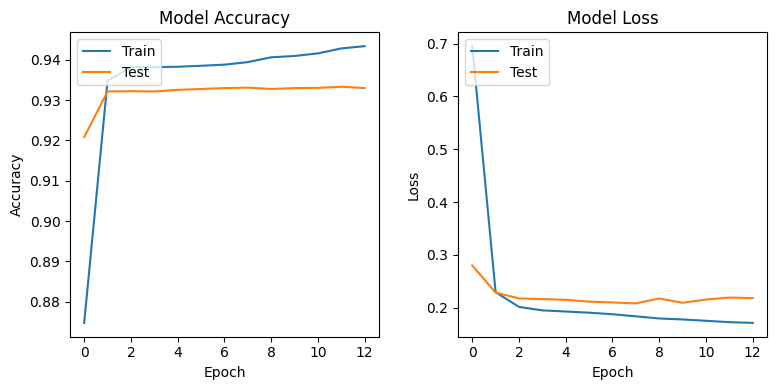

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot accuracy
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['Train', 'Test'], loc='upper left')

# Plot loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(['Train', 'Test'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()


### CNN + BiLSTM

In [53]:
def create_cnn_bilstm(vocab_size, max_len, embeddings_weights, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=300,
                        input_length=max_len,
                        weights=[embeddings_weights],
                        trainable=False))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(Bidirectional(LSTM(50, return_sequences=True)))
    model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_bilstm_model = create_cnn_bilstm(vocab_size, max_len, embedding_matrix, len(pos_keywords))


In [54]:
callbacks =[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

cnn_history =cnn_bilstm_model.fit(
                        train_x, train_y,
                        validation_split=0.1,
                        epochs=50,
                        verbose=1,
                        callbacks=callbacks
                       )

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 220ms/step - accuracy: 0.7649 - loss: 2.5622 - val_accuracy: 0.9285 - val_loss: 0.4568
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9354 - loss: 0.2981 - val_accuracy: 0.9314 - val_loss: 0.2396
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9391 - loss: 0.2041 - val_accuracy: 0.9320 - val_loss: 0.2182
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9393 - loss: 0.1911 - val_accuracy: 0.9329 - val_loss: 0.2145
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9399 - loss: 0.1872 - val_accuracy: 0.9338 - val_loss: 0.2117
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9428 - loss: 0.1808 - val_accuracy: 0.9341 - val_loss: 0.2104
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9428 - loss: 0.1789 - val_accuracy: 0.9345 - val_loss: 0.2085
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9447 - loss: 0.1732 - val_accuracy: 0.9351 -

In [55]:
loss ,acc = cnn_bilstm_model.evaluate(test_x, test_y)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9444 - loss: 0.1744


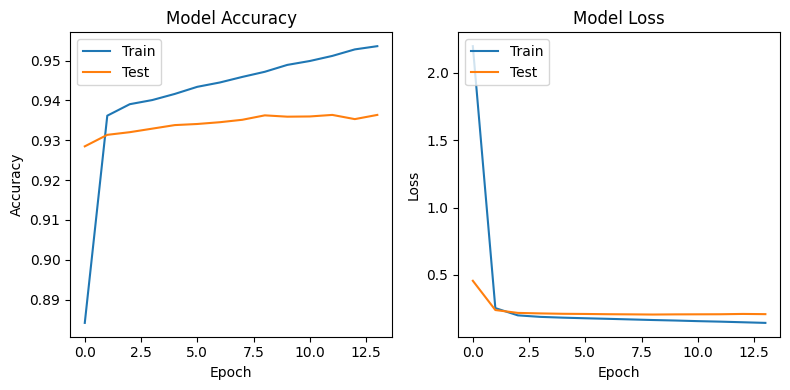

In [56]:
# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot accuracy
axs[0].plot(cnn_history.history['accuracy'])
axs[0].plot(cnn_history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['Train', 'Test'], loc='upper left')

# Plot loss
axs[1].plot(cnn_history.history['loss'])
axs[1].plot(cnn_history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(['Train', 'Test'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()


### BiGRU

In [62]:
def create_bigru(vocab_size, max_len, embeddings_weights, num_classes):
    model = Sequential()

    # Embedding layer with pretrained weights (word2vec)
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=300,
                        input_length=max_len,
                        weights=[embeddings_weights],
                        trainable=False))  # freeze embeddings

    # BiGRU layer
    model.add(Bidirectional(GRU(128, return_sequences=True)))
    model.add(Bidirectional(GRU(100, return_sequences=True)))
    model.add(Bidirectional(GRU(70, return_sequences=True)))
    model.add(Bidirectional(GRU(50, return_sequences=True)))

    # TimeDistributed Dense for sequence labeling
    model.add(TimeDistributed(Dense(num_classes, activation="softmax")))

    # Compile
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    return model


gru_model = create_bigru(vocab_size, max_len, embedding_matrix, len(pos_keywords))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [63]:
callbacks =[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

gru_history = gru_model.fit(
    train_x, train_y,
    validation_split=0.1,
    epochs=50,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 299ms/step - accuracy: 0.7716 - loss: 1.7914 - val_accuracy: 0.9307 - val_loss: 0.2773
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.9364 - loss: 0.2201 - val_accuracy: 0.9317 - val_loss: 0.2197
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.9374 - loss: 0.1961 - val_accuracy: 0.9320 - val_loss: 0.2158
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9379 - loss: 0.1915 - val_accuracy: 0.9325 - val_loss: 0.2171
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9393 - loss: 0.1864 - val_accuracy: 0.9323 - val_loss: 0.2162
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.9415 - loss: 0.1778 - val_accuracy: 0.9332 - val_loss: 0.2174
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9410 - loss: 0.1791 - val_accuracy: 0.9336 - val_loss: 0.2202
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.9441 - loss: 0.1689 - val_accuracy: 0

In [64]:
loss ,acc = gru_model.evaluate(test_x, test_y)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9405 - loss: 0.1852


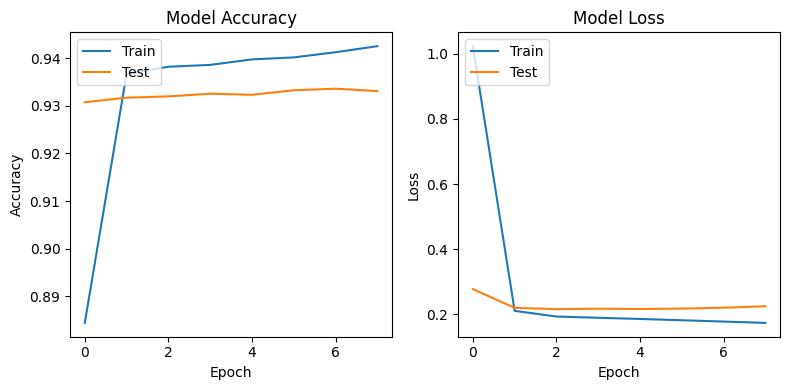

In [65]:
# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot accuracy
axs[0].plot(gru_history.history['accuracy'])
axs[0].plot(gru_history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['Train', 'Test'], loc='upper left')

# Plot loss
axs[1].plot(gru_history.history['loss'])
axs[1].plot(gru_history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(['Train', 'Test'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()

## Save & Load Trained Model

In [66]:
# Save the whole model
model.save("cnn_bilstm_model.keras")

In [67]:
# load saved model
best_model =load_model("cnn_bilstm_model.keras")

## Make Prediction

In [68]:
predict_y=best_model.predict(test_x)

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 340ms/step


In [69]:
predict_y.shape

(300, 257, 16)

In [70]:
#Step2: convert from 1-hot-encoding format to label encoding

def reverse_1hotenc(onehotenc):
    """Convert from one-hot encoding to label indices"""
    decoded = np.argmax(onehotenc, axis=-1)
    return decoded

test_y=reverse_1hotenc(test_y)
predict_y=reverse_1hotenc(predict_y)

In [72]:
predict_y.shape, test_y.shape

((300, 257), (300, 257))

In [73]:
# Map index → POS tag
idx2tag = {i: tag for i, tag in enumerate(pos_keywords)}

def decode_tags(indices):
    return [[idx2tag[idx] for idx in sentence] for sentence in indices]

true_tags = decode_tags(test_y)
pred_tags = decode_tags(predict_y)

In [79]:
sentence_idx = 0
sentence_words = [tok.index_word[idx] for idx in test_x[sentence_idx] if idx != 0]


true_sentence_tags = true_tags[sentence_idx][:len(sentence_words)]
pred_sentence_tags = pred_tags[sentence_idx][:len(sentence_words)]

print("Sentence:", " ".join(sentence_words))
print("True Tags:", true_sentence_tags)
print("Predicted Tags:", pred_sentence_tags)


Sentence: تتواصل التحقيقات والبعثات الاستكشافية إلى الجزيرة
True Tags: ['VERB', 'NOUN', 'CCONJ', 'NOUN', 'ADJ', 'ADP']
Predicted Tags: ['VERB', 'NOUN', 'NOUN', 'NOUN', 'NOUN', 'NOUN']


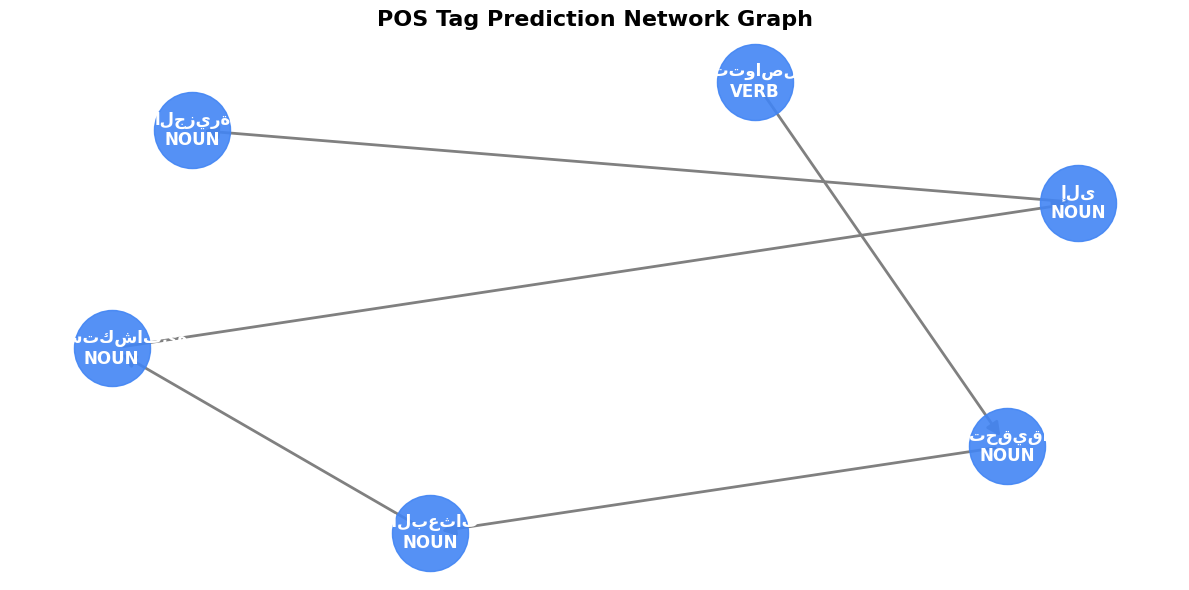

In [81]:
# Add nodes and edges
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
for i, (word, pos_tag) in enumerate(zip(sentence_words, pred_sentence_tags)):
    G.add_node(i, label=f"{word}\n{pos_tag}")

    # Connect word → next word
    if i > 0:
        G.add_edge(i-1, i)

# Draw graph
plt.figure(figsize=(12, 6))
graph_pos = nx.spring_layout(G, k=3, seed=42)

# Draw nodes
nx.draw_networkx_nodes(G, graph_pos, node_color='#4285f4',
                       node_size=3000, alpha=0.9)

# Draw edges
nx.draw_networkx_edges(G, graph_pos, edge_color='gray',
                       arrows=True, arrowsize=20, width=2)

# Add labels (word + POS)
labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, graph_pos, labels, font_size=12,
                        font_color='white', font_weight='bold')

plt.title("POS Tag Prediction Network Graph", size=16, weight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

# Transformers model :
### arabic-camelbert-mix-pos-msa

In [83]:
article= """
ذكرت مجلة فوربس أن العائلة تلعب دورا محوريا في تشكيل علاقة الأفراد بالمال،
 حيث تتأثر هذه العلاقة بأنماط السلوك المالي المتوارثة عبر الأجيال.

التقرير الذي يستند إلى أبحاث الأستاذ الجامعي شاين إنيت حول
الرفاه المالي يوضح أن لكل شخص "شخصية مالية" تتحدد وفقا لطريقة
 تفاعله مع المال، والتي تتأثر بشكل مباشر بتربية الأسرة وتجارب الطفولة.

 الأبعاد الثلاثة للعلاقة بالمال
بحسب الدراسة، هناك ثلاثة أبعاد رئيسية تشكّل علاقتنا بالمال:

الاكتساب (A): يميل الأفراد الذين ينتمون لهذا
 البعد إلى اعتبار المال سلعة قابلة للجمع، حيث يرون
في تحقيق الثروة هدفا بحد ذاته. والجانب السلبي لهذا
 النمط هو إمكانية التحول إلى هوس بالثروة أو العكس،
 أي رفض تام لاكتساب المال باعتباره مصدرا للفساد.

الاستخدام (U): يرى هؤلاء الأشخاص المال أداة للتمتع بالحياة، حيث يربطون قيمته بقدرته على توفير
المتعة والراحة. ومع ذلك، قد يصبح
البعض مدمنا على الإنفاق، في حين يتجه آخرون إلى التقشف المفرط خوفا من المستقبل.

الإدارة (M): أصحاب هذا النمط يعتبرون المال مسؤولية تتطلب التخطيط الدقيق. لكن في بعض الحالات،
 قد يتحول الأمر إلى هوس مفرط بإدارة الإنفاق، مما يؤثر سلبا على العلاقات الشخصية.

 كيف تؤثر العائلة على علاقتنا بالمال؟
يشير التقرير إلى أن التجارب الأسرية تلعب دورا رئيسيا في تحديد
 "الشخصية المالية" لكل فرد، على سبيل المثال، إذا كان أحد الوالدين يعتمد على المال
كمكافأة للسلوك الجيد، فقد يتبنى الطفل لاحقا النمط نفسه في حياته البالغة.

لتحليل هذه التأثيرات بشكل دقيق، طورت رابطة العلاج المالي
(Financial Therapy Association) أداة تسمى مخطط الجينوم المالي (Money Genogram)،
وهو نموذج يُستخدم لتحديد الأنماط المالية داخل العائلة.

تتضمن هذه الأداة:

رسم شجرة عائلية.
تصنيف أفراد العائلة وفقا للأبعاد الثلاثة للعلاقة بالمال (A ،U ،M).
تحديد ما إذا كان السلوك المالي لكل فرد صحيا (+) أو غير صحي (-).
على سبيل المثال، إذا نشأ شخص في عائلة
اعتادت على الإنفاق المفرط، فقد يكون لديه ميل قوي إلى اتباع النمط نفسه،
 أو العكس تماما، حيث يصبح مقتصدا بشكل مبالغ فيه كرد فعل نفسي.
"""

### Data Preprocessing

In [ ]:
def preprocess_with_camel(text: str):
    # Normalize common characters
    text = normalize_alef_ar(text)
    text = normalize_teh_marbuta_ar(text)
    text = normalize_alef_maksura_ar(text)

    # Remove diacritics (harakat)
    text = dediac_ar(text)

    # 3. Remove punctuation
    text = re.sub(r"[.\-؟!,]", " ", text)


    return text

### Loading Model

In [ ]:
# login into huggingface
from huggingface_hub import login
from google.colab import userdata

api_key = userdata.get('HF_Token').strip()
login(api_key)

In [ ]:
from transformers import pipeline

# Correct way to use CAMeLBERT for POS tagging
pos_tagger = pipeline(
    "token-classification",
    model="CAMeL-Lab/bert-base-arabic-camelbert-mix-pos-msa",
    tokenizer="CAMeL-Lab/bert-base-arabic-camelbert-mix-pos-msa",
    aggregation_strategy="simple"
)

In [ ]:
text = preprocess_with_camel(article)
print(text)
results = pos_tagger(text)

for result in results:
    print(f"({result['word']}, '{result['entity_group']}')")

في وقت كانت الموجه الاولي من الربيع العربي وما استتبعته من تعديلات دستوريه في عده دول عربيه وما حصل من سجالات حول موقع الاسلام او الشريعه من هذه التعديلات الدستوريه ومن الدوله عموما والصراعات السياسيه والايديولوجيه بين التيارات الفكريه والسياسيه العربيه الاسلاميه والعلمانيه، ما زالت قائمه او  علي الاقل  ماثله في الاذهان وحاضره في السجال العام، في هذا الوقت المفصلي في التاريخ العربي الحاضر، صدرت الترجمه العربيه لكتاب الدوله المستحيله الاسلام والسياسه ومازق الحداثه الاخلاقي عام ٢٠١٤، ولعل هذا الملحظ حول التوقيت غير ذي اهميه عند مؤلف الكتاب الذي اصدره في سياق اشتغاله الاكاديمي العام بتاريخ الشريعه، وهو الاشتغال الذي انتج اعمالا سبقت هذا الكتاب وتلته  
 لكن كتابه الاهم الشريعه النظريه والممارسه والتحولات الذي سبق الدوله المستحيله في الانجليزيه، والذي يشكل الاخير فرعا عنه واستكمالا له، لم يكن قد صدر بعد بالعربيه حين صدر كتاب الدوله المستحيله، وبهذا فقد الكتاب في النقاش العربي حوله اصلا مهما  لكن هذا السياق الذي يختلف اشد الاختلاف عن سياق صدور الاصل الانجليزي، حدد طبيعه الاستقبال العربي للكت

In [ ]:
text = preprocess_with_camel( "وصفتها الطفلة")
print(text)
results = pos_tagger(text)

for result in results:
    print(f"({result['word']}, '{result['entity_group']}')")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


وصفتها الطفله
(وصفت, 'verb')
(##ها, 'prep')
(الطفله, 'noun')


In [ ]:
results[0:20]

[{'entity_group': 'prep',
  'score': 0.999982,
  'word': 'في',
  'start': 0,
  'end': 2},
 {'entity_group': 'noun',
  'score': 0.9999826,
  'word': 'وقت',
  'start': 3,
  'end': 6},
 {'entity_group': 'verb',
  'score': 0.99997926,
  'word': 'كانت',
  'start': 7,
  'end': 11},
 {'entity_group': 'noun',
  'score': 0.99993956,
  'word': 'الموجه',
  'start': 12,
  'end': 18},
 {'entity_group': 'adj_num',
  'score': 0.9957718,
  'word': 'الاولي',
  'start': 19,
  'end': 25},
 {'entity_group': 'prep',
  'score': 0.999979,
  'word': 'من',
  'start': 26,
  'end': 28},
 {'entity_group': 'noun',
  'score': 0.99975723,
  'word': 'الربيع',
  'start': 29,
  'end': 35},
 {'entity_group': 'adj',
  'score': 0.99984205,
  'word': 'العربي',
  'start': 36,
  'end': 42},
 {'entity_group': 'pron_rel',
  'score': 0.98571473,
  'word': 'وما',
  'start': 43,
  'end': 46},
 {'entity_group': 'verb',
  'score': 0.9999672,
  'word': 'استتبع',
  'start': 47,
  'end': 53},
 {'entity_group': 'prep',
  'score': 0.818

### **NetworKX**

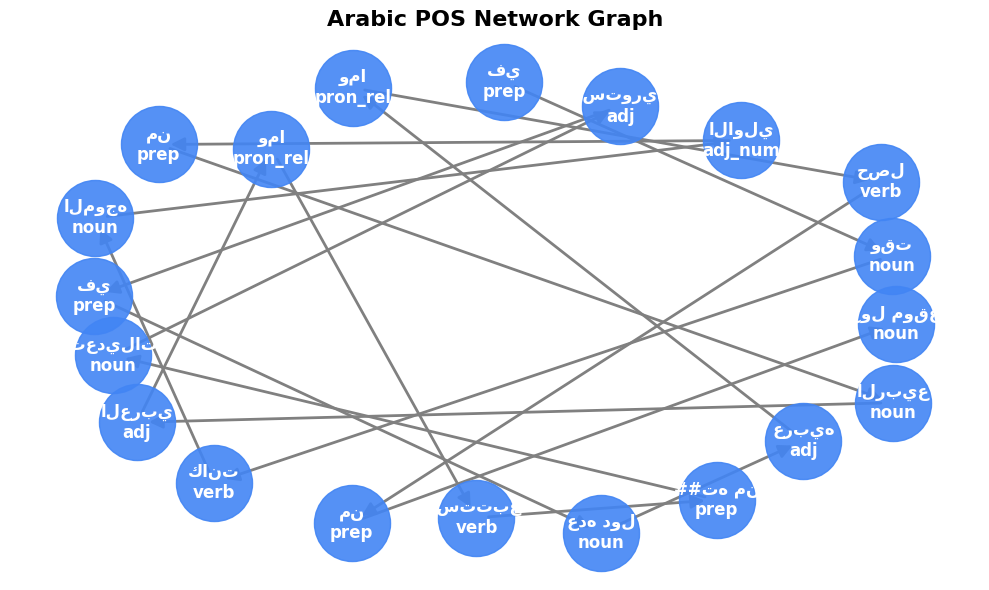

In [ ]:

# Create graph
G = nx.DiGraph()

# Add nodes and edges
for i, result in enumerate(results[0:20]):
    word = result['word']
    pos = result['entity_group']
    G.add_node(i, label=f"{word}\n{pos}")

    # Connect to next word
    if i > 0:
        G.add_edge(i-1, i)

# Draw graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, k=3, seed=42)

# Draw nodes as blue circles
nx.draw_networkx_nodes(G, pos, node_color='#4285f4',
                       node_size=3000, alpha=0.9)

# Draw edges with arrows
nx.draw_networkx_edges(G, pos, edge_color='gray',
                       arrows=True, arrowsize=20, width=2)

# Add labels
labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels, font_size=12,
                        font_color='white', font_weight='bold')

plt.title("Arabic POS Network Graph", size=16, weight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()